In [ ]:
!pip install wget tensorflow pandas numpy keras pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [ ]:
import wget
url = 'https://raw.githubusercontent.com/clinc/oos-eval/master/data/data_full.json'
wget.download(url)

'data_full.json'

In [ ]:
import numpy as np
import json
# Loading json data
with open('data_full.json') as file:
  data = json.loads(file.read())

# Loading out-of-scope intent data
val_oos = np.array(data['oos_val'])
train_oos = np.array(data['oos_train'])
test_oos = np.array(data['oos_test'])

# Loading other intents data
val_others = np.array(data['val'])
train_others = np.array(data['train'])
test_others = np.array(data['test'])

# Merging out-of-scope and other intent data
val = np.concatenate([val_oos,val_others])
train = np.concatenate([train_oos,train_others])
test = np.concatenate([test_oos,test_others])
data = np.concatenate([train,test,val])
data = data.T

text = data[0]
labels = data[1]

In [ ]:
from sklearn.model_selection import train_test_split
train_X,test_X,train_y,test_y = train_test_split(text,labels,test_size = 0.3)

In [ ]:
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_num_words = 40000
classes = np.unique(labels)

tokenizer = Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(train_X)
word_index = tokenizer.word_index

In [ ]:
ls=[]
for c in train_X:
    ls.append(len(c.split()))
maxLen=int(np.percentile(ls, 98))
train_sequences = tokenizer.texts_to_sequences(train_X)
train_sequences = pad_sequences(train_sequences, maxlen=maxLen,              padding='post')
test_sequences = tokenizer.texts_to_sequences(test_X)
test_sequences = pad_sequences(test_sequences, maxlen=maxLen, padding='post')

In [ ]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(classes)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoder.fit(integer_encoded)
train_label_encoded = label_encoder.transform(train_y)
train_label_encoded = train_label_encoded.reshape(len(train_label_encoded), 1)
train_label = onehot_encoder.transform(train_label_encoded)
test_labels_encoded = label_encoder.transform(test_y)
test_labels_encoded = test_labels_encoded.reshape(len(test_labels_encoded), 1)
test_labels = onehot_encoder.transform(test_labels_encoded)

In [ ]:
import wget
url ='https://www.dropbox.com/s/a247ju2qsczh0be/glove.6B.100d.txt?dl=1'
wget.download(url)

'glove.6B.100d.txt'

In [ ]:
embeddings_index={}
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [ ]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
num_words = min(max_num_words, len(word_index))+1
embedding_dim=len(embeddings_index['the'])
embedding_matrix = np.random.normal(emb_mean, emb_std, (num_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_num_words:
        break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Bidirectional,Embedding
model = Sequential()

model.add(Embedding(num_words, 100, trainable=False,input_length=train_sequences.shape[1], weights=[embedding_matrix]))
model.add(Bidirectional(LSTM(256, return_sequences=True, recurrent_dropout=0.1, dropout=0.1), 'concat'))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=False, recurrent_dropout=0.1, dropout=0.1))
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(classes.shape[0], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
history = model.fit(train_sequences, train_label, epochs = 20,
          batch_size = 64, shuffle=True,
          validation_data=[test_sequences, test_labels])

Epoch 1/20
260/260 [==============================] - 63s 210ms/step - loss: 4.6763 - acc: 0.0500 - val_loss: 3.8984 - val_acc: 0.0969
Epoch 2/20
260/260 [==============================] - 53s 204ms/step - loss: 3.3631 - acc: 0.1495 - val_loss: 2.3076 - val_acc: 0.3831
Epoch 3/20
260/260 [==============================] - 54s 209ms/step - loss: 2.2216 - acc: 0.3744 - val_loss: 1.4806 - val_acc: 0.5835
Epoch 4/20
260/260 [==============================] - 54s 209ms/step - loss: 1.5974 - acc: 0.5396 - val_loss: 1.0798 - val_acc: 0.7015
Epoch 5/20
260/260 [==============================] - 54s 206ms/step - loss: 1.2368 - acc: 0.6403 - val_loss: 0.8766 - val_acc: 0.7579
Epoch 6/20
260/260 [==============================] - 53s 205ms/step - loss: 0.9944 - acc: 0.7130 - val_loss: 0.8079 - val_acc: 0.7717
Epoch 7/20
260/260 [==============================] - 53s 204ms/step - loss: 0.8388 - acc: 0.7608 - val_loss: 0.6998 - val_acc: 0.8120
Epoch 8/20
260/260 [==============================] - 5

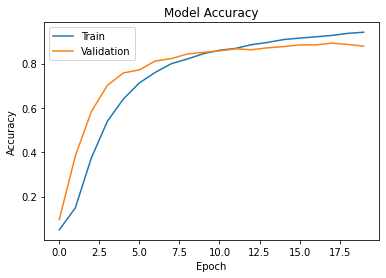

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

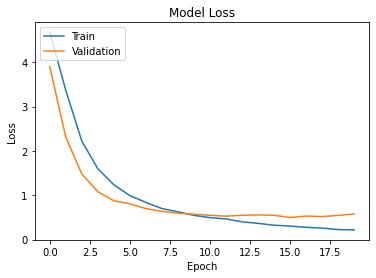

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
import pickle
import json
model.save('models/intents.h5')

with open('utils/classes.pkl','wb') as file:
   pickle.dump(classes,file)

with open('utils/tokenizer.pkl','wb') as file:
   pickle.dump(tokenizer,file)

with open('utils/label_encoder.pkl','wb') as file:
   pickle.dump(label_encoder,file)

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
class IntentClassifier:
    def __init__(self,classes,model,tokenizer,label_encoder):
        self.classes = classes
        self.classifier = model
        self.tokenizer = tokenizer
        self.label_encoder = label_encoder

    def get_intent(self,text):
        self.text = [text]
        self.test_keras = self.tokenizer.texts_to_sequences(self.text)
        self.test_keras_sequence = pad_sequences(self.test_keras, maxlen=16, padding='post')
        self.pred = self.classifier.predict(self.test_keras_sequence)
        return self.label_encoder.inverse_transform(np.argmax(self.pred,1))[0]

In [ ]:
nlu = IntentClassifier(classes,model,tokenizer,label_encoder)
print(nlu.get_intent("Hey!"))
# Prints 'weather'

1/1 [==============================] - 0s 54ms/step
greeting
